Нью-Йоркская комиссия по такси и лимузинам (TLC) предоставляет подробные анонимизированные данные о поездках клиентов с 2009 года. Машины, выкрашенные жёлтым, имеют право брать пассажиров на улицах в любом из пяти боро города.
Сырые данные о поездках в жёлтом такси можно найти на сайте TLC: www.nyc.gov/html/tlc/html/about/trip_record_data.shtml Эти данные разбиты на файлы по месяцам. В каждом из файлов содержится следующая информация о поездках:

- время начала поездки
- время окончания поездки
- долгота и широта точки начала поездки
- долгота и широта точки окончания поездки
- количество пассажиров
- расстояние по счётчику
- тип тарифа (одна из шести категорий)
- способ оплаты (одна из шести категорий)
- стоимость поездки по счётчику
- налог на счётчик
- доплата за поездки в пиковые часы и ночью
- доплата за проезд по платным дорогам
- доплата за проезд, взимаемая с каждой поездки с января 2015
- размер чаевых
- общая стоимость поездки
- провайдер данных (одна из двух категорий)
- бинарный флаг, показывающий, были ли данные о поезде получены немедленно после её окончания, или какое-то время хранились в памяти автомобиля.

Подробнее: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

Чтобы улучшить такую модель, можно попытаться учесть:

- взаимосвязи между рядами
- дополнительные параметры поездок, которые можно посчитать по исходным данным
- внешние календарные и географические признаки

# Задание неделя 3
Основная сложность работы с такими рядами, как в нашем проекте, заключается в том, как учесть сложную структуру сезонности — суточной, недельной и годовой. В рамках моделей ARIMA можно учесть только одну из них. Обычно в таких случаях сезонность с самым маленьким периодом явно моделируют с помощью аримы, а все остальные учитывают за счёт регрессионной компоненты.

Для учёта недельной сезонности используются регрессионные признаки следующего вида:

$$s_i=sin([1,…,T]∗2πi/168), c_i=cos([1,…,T]∗2πi/168),i=1,…,K.$$
Здесь T — это длина моделируемого ряда, 168 — длительность недели в часах, а значение параметра K вам предстоит подобрать самостоятельно (в зависимости от длины подготовленного ряда, можно для начала взять K равным 2-5).

Если вы собрали данные за несколько лет, аналогичные признаки можно использовать для учёта годовой сезонности. Длина года — 8766 часов.

Если в данных есть линейный или описываемый ещё какой-то простой функцией f тренд, стоит добавить к регрессионным признакам вектор [1,…,T] или, соответственно, f([1,…,T]).

Если вы забыли, как в statsmodels работать с моделями ARIMA, почитайте туториал от создателей.

1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок. <b>Не используйте данные за последний имеющийся месяц!</b> Создайте регрессионные признаки для учёта сезонностей и трендов.
2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.
3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.
4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров p,q,P,Q. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
5. Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов K или поменять порядки дифференцирования.
6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.

In [1]:
%run -n main_3.py
%pylab inline

/Users/admin/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Populating the interactive namespace from numpy and matplotlib


# 1.
### 1.1 Загрузим предварительные данные и обработаем их
Будем обрабатывать регион наугад - 1278

In [2]:
region_id = 1278
period = 7 # недельный период
data_df, files = load_data()

HBox(children=(IntProgress(value=0, max=18), HTML(value='')))

In [3]:
data_1278 = data_df[data_df['region'] == region_id].drop(['region'], axis=1).set_index('date')
data_1278.head()

,0 hours,1 hours,2 hours,3 hours,4 hours,5 hours,6 hours,7 hours,8 hours,9 hours,...,14 hours,15 hours,16 hours,17 hours,18 hours,19 hours,20 hours,21 hours,22 hours,23 hours
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,58.0,83.0,81.0,59.0,40.0,18.0,17.0,12.0,12.0,17.0,...,19.0,12.0,9.0,17.0,11.0,25.0,8.0,14.0,8.0,11.0
2015-01-02,7.0,6.0,7.0,4.0,4.0,10.0,15.0,18.0,22.0,30.0,...,17.0,6.0,9.0,14.0,15.0,15.0,18.0,17.0,13.0,20.0
2015-01-03,22.0,17.0,25.0,13.0,9.0,8.0,13.0,10.0,19.0,34.0,...,22.0,16.0,8.0,14.0,23.0,23.0,20.0,25.0,18.0,32.0
2015-01-04,25.0,18.0,11.0,12.0,12.0,7.0,11.0,7.0,15.0,20.0,...,19.0,12.0,14.0,11.0,11.0,14.0,17.0,10.0,11.0,5.0
2015-01-05,7.0,4.0,4.0,2.0,1.0,9.0,17.0,16.0,17.0,17.0,...,22.0,10.0,3.0,13.0,13.0,12.0,11.0,6.0,10.0,11.0


Просуммируем количество поездок по дням и заодно посмотрим на тенденцию

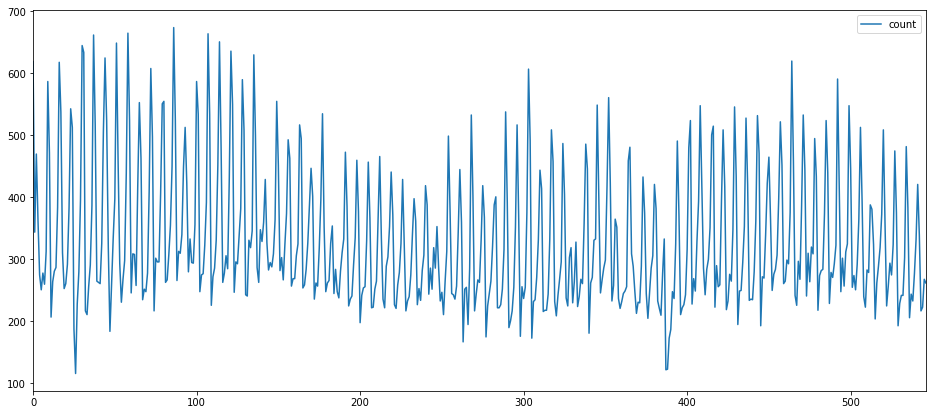

In [4]:
data = pd.DataFrame(data_1278.index.values, columns=['date'])
data['count'] = data_1278.sum(axis=1).values
data.plot(y='count',figsize=(16,7));

по графику наблюдается временная зависимость, особенно это заметно на период весны

### 1.2 Зададим регрессионные признаки
Пусть K = 5

In [5]:
K = 5
data_s = pd.DataFrame(generate_sin_reg(data.shape[0], K, period_len=7).T,
                      columns=[f's%s' % i for i in np.arange(1, K+1)])
data_c = pd.DataFrame(generate_cos_reg(data.shape[0], K, period_len=7).T,
                      columns=[f'c%s' % i for i in np.arange(1, K+1)])

In [6]:
data = pd.concat([data, data_s, data_c], axis=1).set_index('date')

### 1.3 Зададим признак праздников и выходных, возможно эта зависимость поможет нам лучше понять картину

In [7]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
cal = calendar()
holidays = cal.holidays(start=data.index.min(), end=data.index.max())
data['holiday'] = data.index.isin(holidays).astype('int')

In [8]:
data['weekday'] = data.index.weekday

In [9]:
data.head()

,count,s1,s2,s3,s4,s5,c1,c2,c3,c4,c5,holiday,weekday
date,,,,,,,,,,,,,
2015-01-01,619.0,0.781831,0.974928,0.433884,-0.433884,-0.974928,0.623490,-0.222521,-0.900969,-0.900969,-0.222521,1,3
2015-01-02,344.0,0.974928,-0.433884,-0.781831,0.781831,0.433884,-0.222521,-0.900969,0.623490,0.623490,-0.900969,0,4
2015-01-03,470.0,0.433884,-0.781831,0.974928,-0.974928,0.781831,-0.900969,0.623490,-0.222521,-0.222521,0.623490,0,5
2015-01-04,364.0,-0.433884,0.781831,-0.974928,0.974928,-0.781831,-0.900969,0.623490,-0.222521,-0.222521,0.623490,0,6
2015-01-05,275.0,-0.974928,0.433884,0.781831,-0.781831,-0.433884,-0.222521,-0.900969,0.623490,0.623490,-0.900969,0,0


# 2.
### 2.1 Построим регрессионную модель

In [10]:
X = data.loc[:, 's1':]
y = data['count']

In [11]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(X=X, y=y)
y_pred = model.predict(X)

### 2.2 Проанализируем ошибки модели

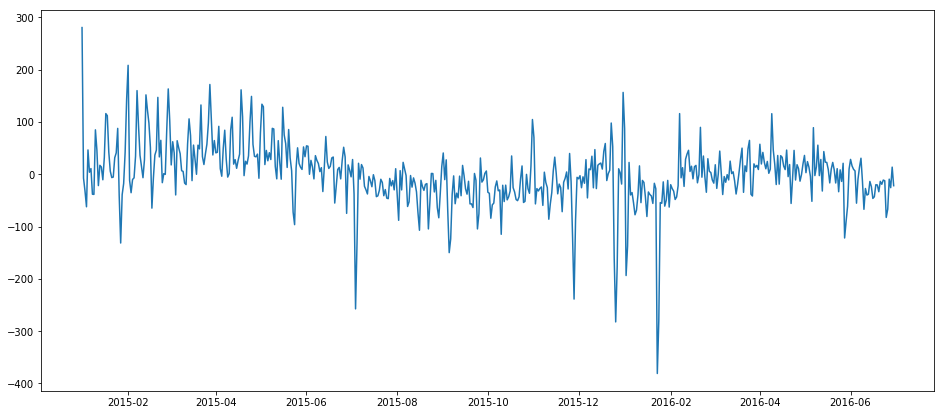

In [12]:
errors = y - y_pred
plt.figure(figsize=(16, 7))
plt.plot(errors)
plt.show()

На графике видно, что ошибки имеют некоторую периодичность, но не сказал бы что ярко выраженную. Есть некоторые выбросы, но скорее всего это особые ситуации, может праздники или что-то случилось в городе. Однако на начало 2016 года тренд становится более ярко выражен.

In [13]:
# критерий Дики-Фуллера
stattools.adfuller(errors)

(-2.7212315189821235,
 0.070435795454344821,
 12,
 534,
 {'1%': -3.4426552678216003,
  '10%': -2.569660749624767,
  '5%': -2.8669676577777548},
 5544.5387837156995)

Видим, что p-value=0.07 => нулевую гипотезу не можем отвергнуть на уровне 0.05, но этого недостаточно.

Построим STL декомпозицию

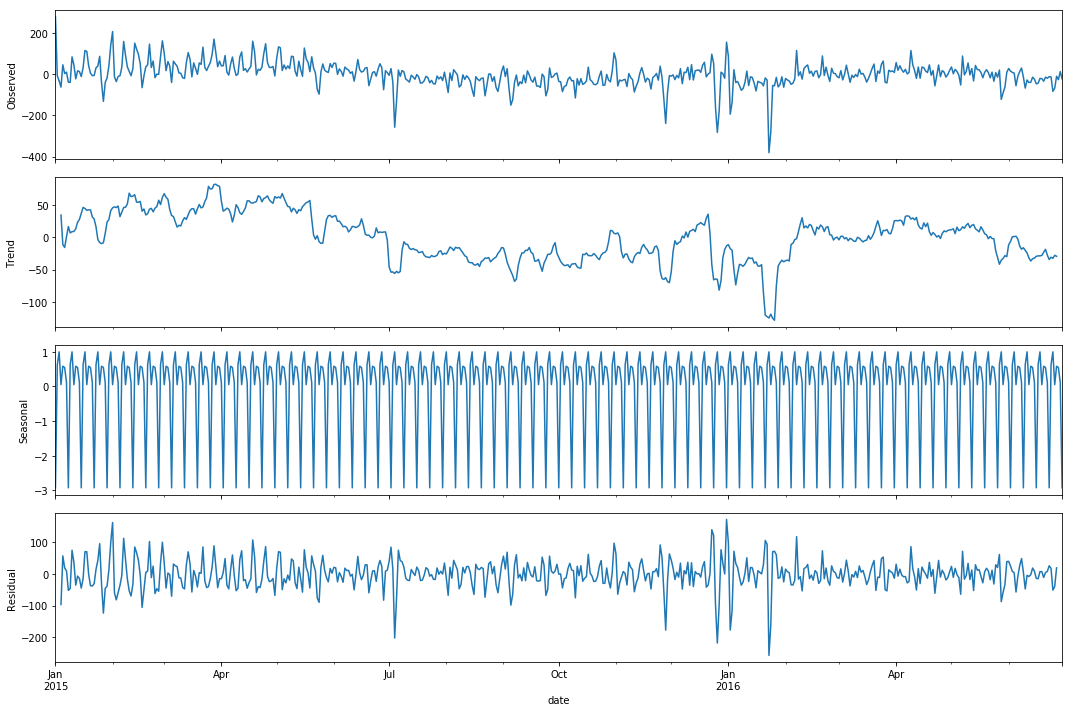

In [14]:
plt.figure(figsize(15,10))
seasonal.seasonal_decompose(errors).plot();

Наблюдается отчетливый нисходящий тренд в разрезе года, сезонность видна на лицо.

Остаточный шум достаточно выравнен. 

Попробуем стабилизровать и избавиться от тренда.

# 3. Попробуем сделать ряд остатков стационарным
Продифференцируем в разрезе недели

In [15]:
errors_diff = errors - errors.shift(period)

In [16]:
# критерий Дики-Фуллера
stattools.adfuller(errors_diff[period:])

(-6.6435710269089681,
 5.3345369045418319e-09,
 19,
 520,
 {'1%': -3.4429882202506255,
  '10%': -2.569738849852071,
  '5%': -2.8671142122781066},
 5558.0378975339727)

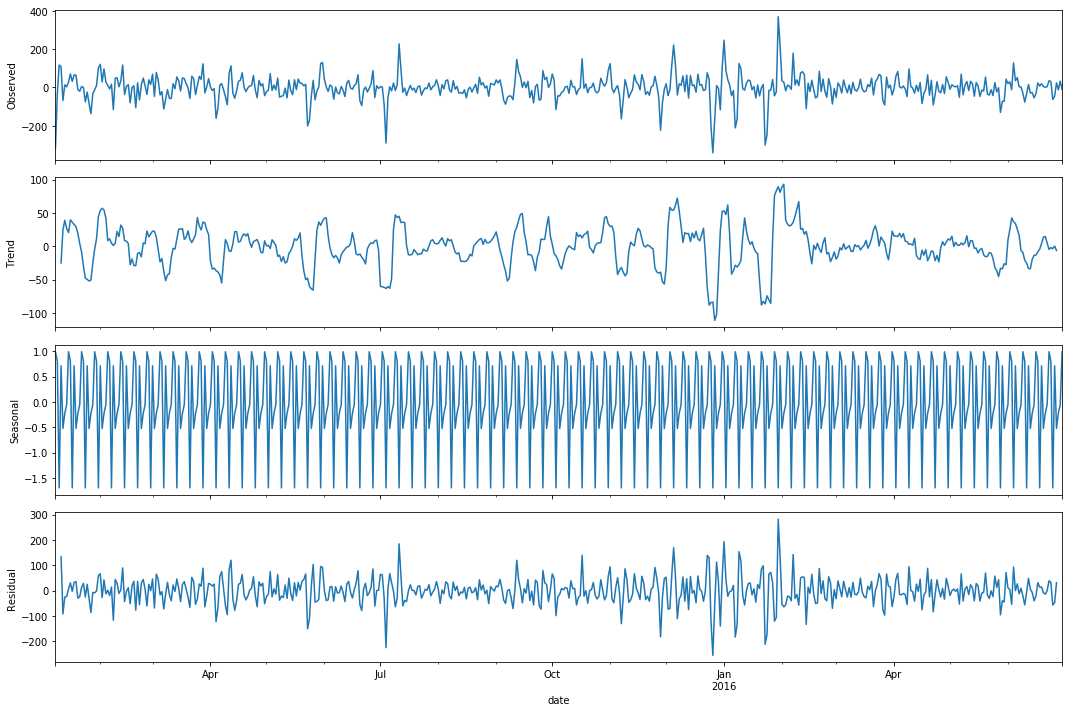

In [17]:
plt.figure(figsize(15,10))
seasonal.seasonal_decompose(errors_diff[period:]).plot();

В принципе мы уже избавились от тренда, попробуем добавить обычное дифференцирование для надежности

In [18]:
errors_diff2 = errors_diff - errors_diff.shift(1)

In [19]:
# критерий Дики-Фуллера
stattools.adfuller(errors_diff[period+1:])

(-6.6611449713003061,
 4.8436739082443004e-09,
 19,
 519,
 {'1%': -3.4430126933746767,
  '10%': -2.569744590233924,
  '5%': -2.8671249839002764},
 5548.0198828588582)

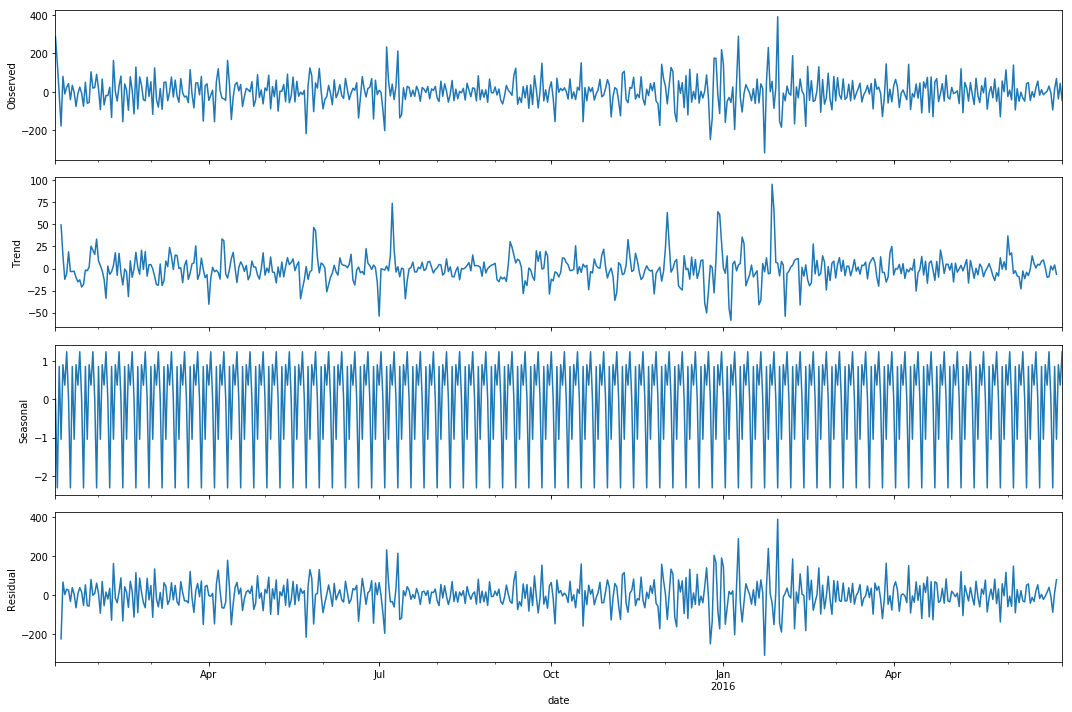

In [20]:
plt.figure(figsize(15,10))
seasonal.seasonal_decompose(errors_diff2[period+1:]).plot();

Отлично, продолжаем

# 4.
Выбор начальных приближений для p,q,P,Q

### 4.1 Посмотрим на ACF

In [21]:
diff = errors_diff2[period+1:]

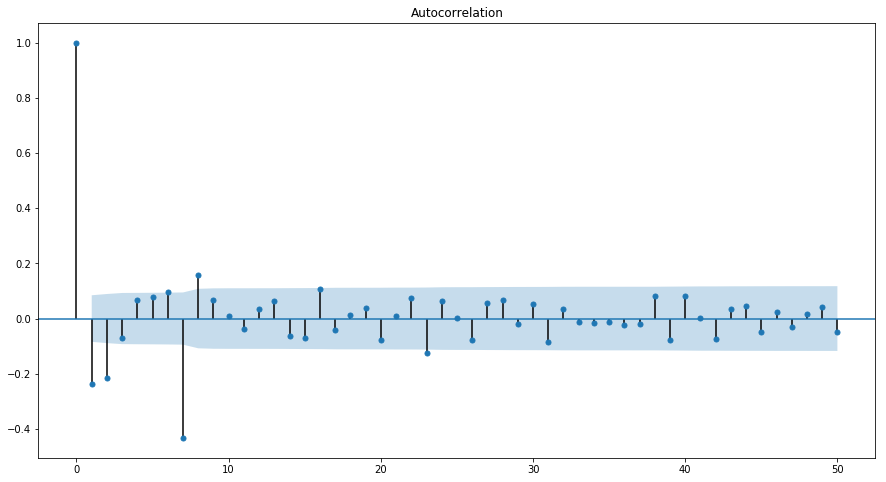

In [22]:
plt.figure(figsize(15,8))
tsaplots.plot_acf(diff.values.squeeze(), lags=50);

In [23]:
Q = 1
q = 7

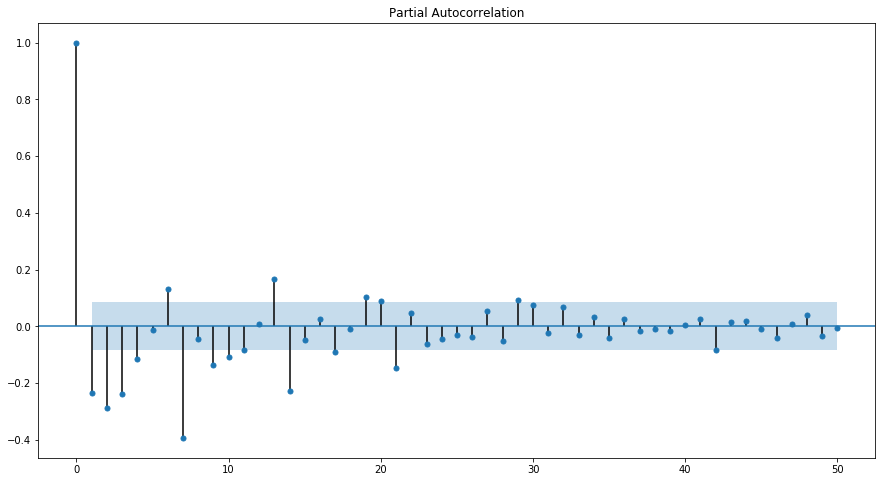

In [24]:
plt.figure(figsize(15,8))
tsaplots.plot_pacf(diff.values.squeeze(), lags=50);

In [25]:
P = 0
p = 2

### 4.2 Обучение и сравнение моделей-кандидатов, выбор победителя

In [26]:
ps = range(0, p+1)
d=1
qs = range(0, q+1)
Ps = range(0, P+1)
D=1
Qs = range(0, Q+1)

In [27]:
parameters = prd(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

# 5. Выбор оптимальной модели

In [28]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = SARIMAX(y, exog=X, order=(param[0], d, param[1]), 
                        seasonal_order=(param[2], D, param[3], period),
                        time_varying_regression=True, mle_regression=False).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (0, 7, 0, 0)
wrong parameters: (0, 7, 0, 1)
wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 3, 0, 0)
wrong parameters: (1, 3, 0, 1)
wrong parameters: (1, 7, 0, 0)
wrong parameters: (1, 7, 0, 1)
wrong parameters: (2, 7, 0, 0)
wrong parameters: (2, 7, 0, 1)
CPU times: user 11min 10s, sys: 4.02 s, total: 11min 14s
Wall time: 7min 12s


In [29]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
13  (1, 0, 0, 0)  5651.128840
0   (0, 0, 0, 1)  5651.955025
23  (2, 0, 0, 0)  5653.179037
15  (1, 2, 0, 0)  5658.186652
3   (0, 2, 0, 0)  5658.964763


лучшая модель

In [30]:
print(best_model.summary())

                                 Statespace Model Results                                
Dep. Variable:                             count   No. Observations:                  547
Model:             SARIMAX(1, 1, 0)x(0, 1, 0, 7)   Log Likelihood               -2811.564
Date:                           Sun, 21 Jan 2018   AIC                           5651.129
Time:                                   16:44:29   BIC                           5711.391
Sample:                               01-01-2015   HQIC                          5674.684
                                    - 06-30-2016                                         
Covariance Type:                             opg                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
ar.L1          -0.2198          0       -inf      0.000      -0.220      -0.220
var.s1       1.494e-05      1.672   8.93

/Users/admin/anaconda/lib/python3.6/site-packages/statsmodels/base/model.py:1036: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/admin/anaconda/lib/python3.6/site-packages/statsmodels/tsa/statespace/mlemodel.py:1964: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/Users/admin/anaconda/lib/python3.6/site-packages/numpy/linalg/linalg.py:1487: RuntimeWarning: divide by zero encountered in true_divide
  return s[..., 0]/s[..., -1]


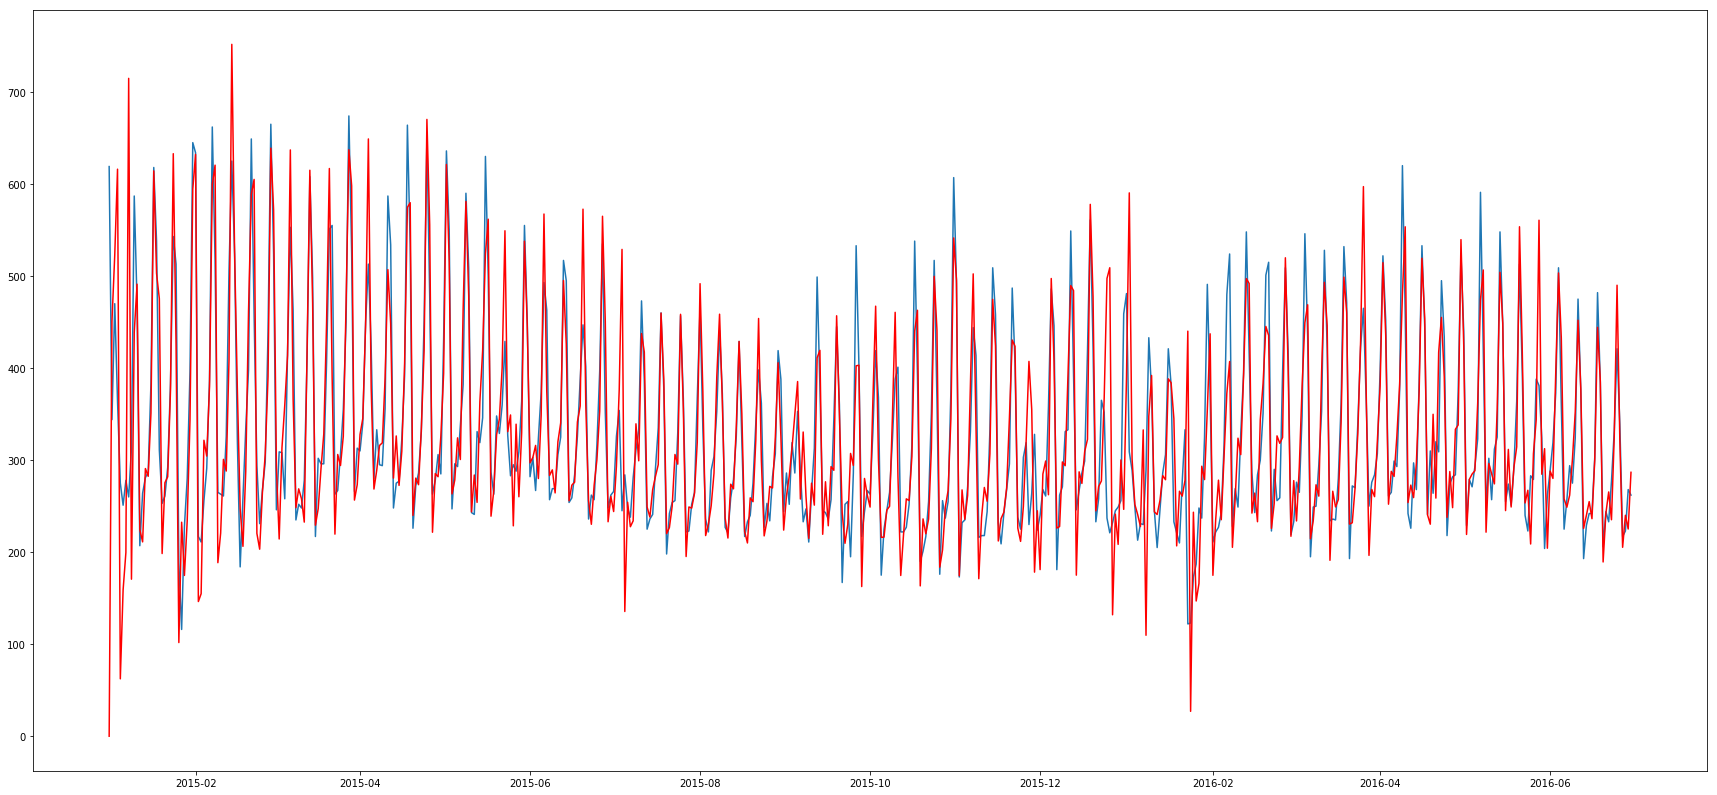

In [31]:
model_data = best_model.fittedvalues
plt.figure(figsize(30,14))
plt.plot(y)
plt.plot(model_data, color='r')
pylab.show()

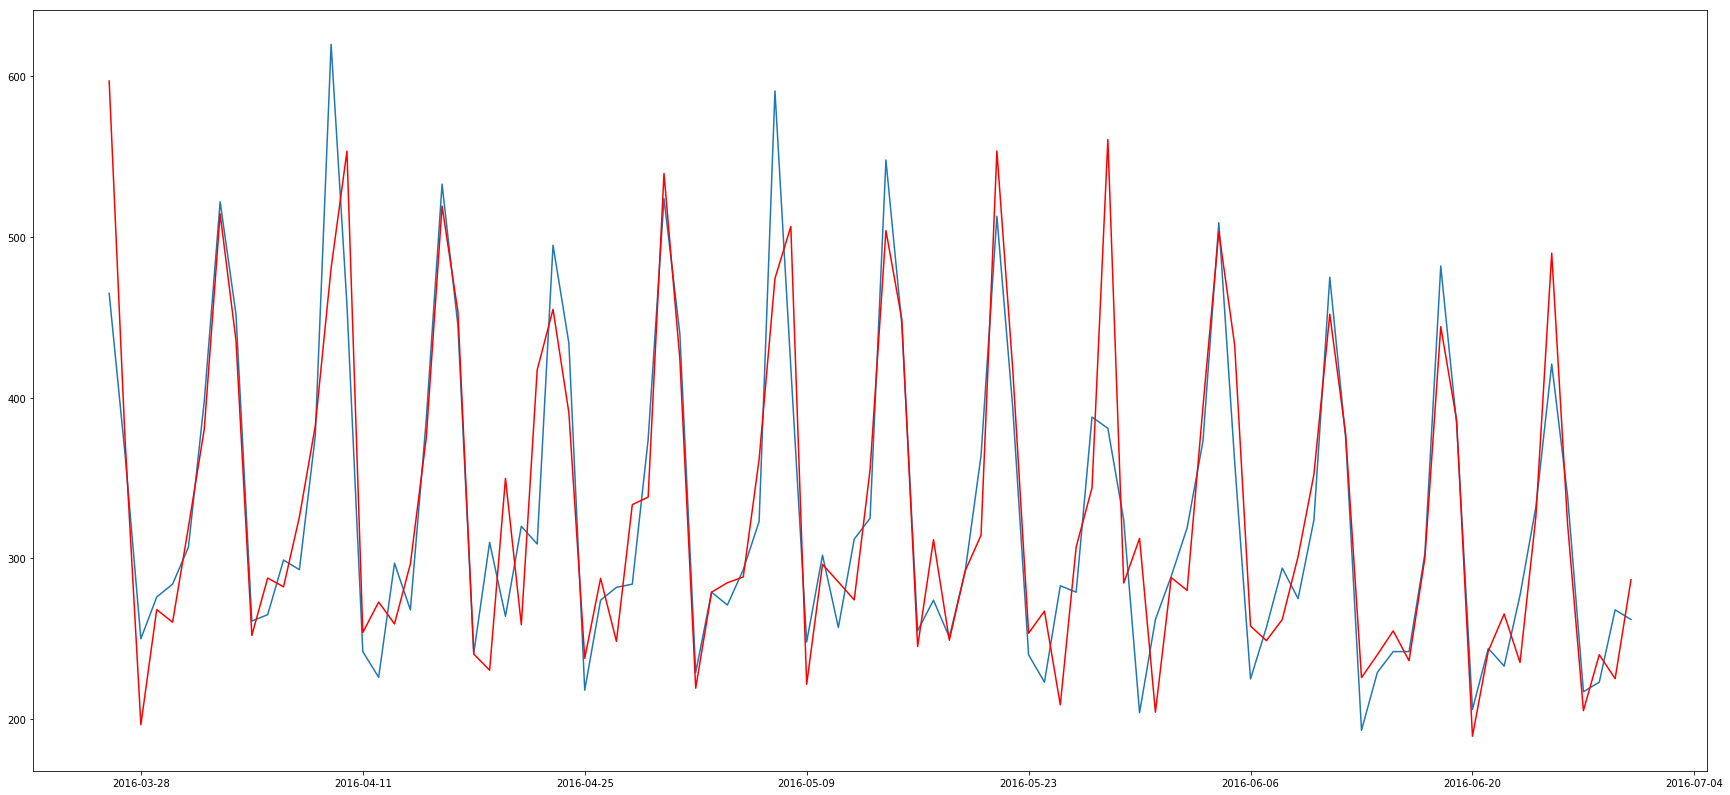

In [32]:
plt.figure(figsize(30,14))
plt.plot(y[450:])
plt.plot(model_data[450:], color='r')
pylab.show()

# 6. Выводы
В принципе модель довольно неплохо справилась с приближением к исходным данным, но есть небольшые выбросы, скорее всег освязанные с какими-то местными событиями или авариями, климатическиеми условыями. В работе была попытка добавить пару признаков - это день недели и праздники в США. Возможно есть еще способы не рассмотренные в данной работе.